In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Compose
import matplotlib.pyplot as plt
import numpy as np

import os
import pickle

import h5py
import scipy
from PIL import Image
from scipy import ndimage

In [6]:
train_dataset = datasets.CIFAR10(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = datasets.CIFAR10(root='data/', download=True, train=False, transform=ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f,encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
    return X, Y
def load_CIFAR10():
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join('data', 'cifar-10-batches-py', 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)    
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join('data', 'cifar-10-batches-py', 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [12]:
X_train, y_train, X_test, y_test = load_CIFAR10()

In [13]:
X_train, y_train, X_test, y_test = split(50000,X_train,y_train,0.2)
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(40000,)
(10000, 32, 32, 3)
(10000,)


In [17]:
    K = [2*k+1 for k in range(1,6)]
    result = []
    for k in K:
        clf_kmeans = KMeans(K=k, max_iters=150)
        clf_kmeans.fit(X_train,y_train)
        y_pred = clf_kmeans.predict(X_train,X_test)
        accu = accuracy(y_test,y_pred)
        print(accu)
        result.append(accu)
    print(result)

0.1765
0.1828
0.196
0.2189
0.2303
[0.1765, 0.1828, 0.196, 0.2189, 0.2303]


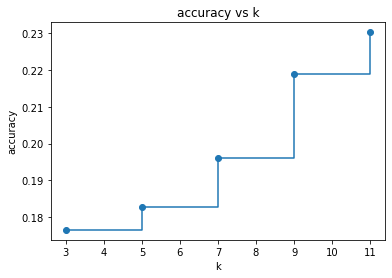

In [18]:
fig, ax = plt.subplots()
ax.set_xlabel("k")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs k")
ax.plot(K, result, marker="o", drawstyle="steps-post")

plt.show()

In [20]:
X_train, y_train, X_test, y_test = load_CIFAR10()

In [21]:
X_train = X_train[0:50000]
X_test = X_test[0:10000]
y_train = y_train[0:50000]
y_test = y_test[0:10000]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [22]:
    K = [2*k+1 for k in range(1,6)]
    result = []
    for k in K:
        clf_kmeans = KMeans(K=k, max_iters=150)
        clf_kmeans.fit(X_train,y_train)
        y_pred = clf_kmeans.predict(X_train,X_test)
        accu = accuracy(y_test,y_pred)
        print(accu)
        result.append(accu)
    print(result)

0.1753
0.1978
0.1987
0.2174
0.2311
[0.1753, 0.1978, 0.1987, 0.2174, 0.2311]


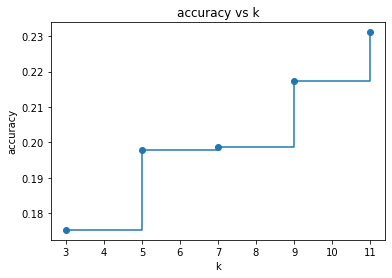

In [23]:
fig, ax = plt.subplots()
ax.set_xlabel("k")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs k")
ax.plot(K, result, marker="o", drawstyle="steps-post")

plt.show()

In [19]:
from collections import Counter

def split(n_samples,X,y,k):
    random_sample_idxs = np.random.choice(n_samples, int(n_samples*k), replace=False)
    X_test = np.array([X[i] for i in random_sample_idxs])
    y_test = np.array([y[i] for i in random_sample_idxs])
    X_train = np.array([X[i] for i in range(n_samples) if i not in random_sample_idxs])
    y_train = np.array([y[i] for i in range(n_samples) if i not in random_sample_idxs])
    return X_train,y_train,X_test,y_test

def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

def accuracy(y_true, y_pred):
    y_true = np.ravel(y_true.T)
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

class KMeans:
    def __init__(self, K=5, max_iters=100):
        self.K = K
        self.max_iters = max_iters
        self.clusters = [[] for _ in range(self.K)]
        self.centroids = []
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        
    def predict(self,X, X_test):
        self.X = X
        self.n_samples = X.shape[0]

        random_sample_idxs = np.random.choice(self.n_samples, self.K, replace=False)
        self.centroids = [self.X[idx] for idx in random_sample_idxs]

        for _ in range(self.max_iters):

            self.clusters = self._create_clusters(self.centroids)

            centroids_old = self.centroids
            self.centroids = self._get_centroids(self.clusters)

            if self._is_converged(centroids_old, self.centroids):
                break

        return self._get_cluster_labels(self.clusters,X_test)

    def _get_cluster_labels(self, clusters, X_test):
 
        labels = np.empty(X_test.shape[0])
        ans = []
        
        for cluster in clusters:
            cluster_labels = [ y_train[i] for i in cluster]
            most_common = Counter(cluster_labels).most_common(1)[0][0]
            ans.append(most_common)
            
        for idx, sample in enumerate(X_test):
            labels[idx] = ans[self._closest_centroid(sample,self.centroids)]
        return labels

    def _create_clusters(self, centroids):

        clusters = [[] for _ in range(self.K)]
        for idx, sample in enumerate(self.X):
            centroid_idx = self._closest_centroid(sample, centroids)
            clusters[centroid_idx].append(idx)
        return clusters

    def _closest_centroid(self, sample, centroids):

        distances = [euclidean_distance(sample, point) for point in centroids]
        closest_index = np.argmin(distances)
        return closest_index

    def _get_centroids(self, clusters):

        centroids = np.zeros((self.K, 32, 32 ,3))
        for cluster_idx, cluster in enumerate(clusters):
            cluster_mean = np.mean(self.X[cluster], axis=0)
            centroids[cluster_idx] = cluster_mean
        return centroids

    def _is_converged(self, centroids_old, centroids):

        distances = [
            euclidean_distance(centroids_old[i], centroids[i]) for i in range(self.K)
        ]
        return sum(distances) == 0

In [50]:
    K = [2*k+1 for k in range(1,6)]
    result = []
    for k in K:
        clf_kmeans = KMeans(K=k, max_iters=150)
        clf_kmeans.fit(X_train,y_train)
        y_pred = clf_kmeans.predict(X_train,X_test)
        accu = accuracy(y_test,y_pred)
        print(accu)
        result.append(accu)
    print(result)

0.1753
0.1973
0.1989
0.2168
0.2376
[0.1753, 0.1973, 0.1989, 0.2168, 0.2376]


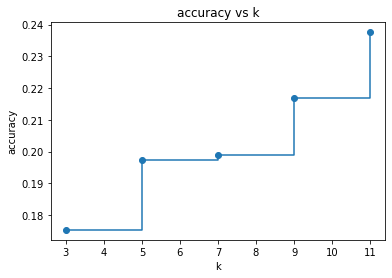

In [51]:
fig, ax = plt.subplots()
ax.set_xlabel("k")
ax.set_ylabel("accuracy")
ax.set_title("accuracy vs k")
ax.plot(K, result, marker="o", drawstyle="steps-post")

plt.show()